<a href="https://colab.research.google.com/github/xixihaha1995/esp_proj3/blob/main/ESP2022_Proj3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Energy Prediction based on Machine Learning
## Mount to GoogleDrive

In [9]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/studying/Summer 2022/Project3/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/studying/Summer 2022/Project3


In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

## Import modules

In [37]:
import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

## Hyperparameters and Neural Network setup

In [54]:
lookback = 90
test_portion_factor = 0.3

lr = 0.001
hidden_dim=256
EPOCHS=5
model_type = "GRU"
output_dim = 1
n_layers = 2

'''
new_cols[0] is the target y
new_cols[1:] are input x
'''
new_cols = ['elec_hvac[J]','month','dayofmonth','dayofweek', 'hour', 'minute',
        'oat[C]', 'solar[W/m2]']
print(f'Target variable:{new_cols[0]}')
print(f'Input features:{new_cols[1:]}')

Target variable:elec_hvac[J]
Input features:['month', 'dayofmonth', 'dayofweek', 'hour', 'minute', 'oat[C]', 'solar[W/m2]']


In [39]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [40]:
def train(model, train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    # input_dim = next(iter(train_loader))[0].shape[2]
    # output_dim = 1
    # n_layers = 2
    # Instantiating the models
    # if model_type == "GRU":
    #     model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    # else:
    #     model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    # model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

## Preview the training data

In [41]:
# Define data root directory
data_dir = "./data/"
print(os.listdir(data_dir))
pd.read_csv(data_dir + 'pyep_results.csv').head()

['pyep_results.csv']


,timestamp,oat[C],elec_hvac[J],solar[W/m2],zone_load_rate[W]
0,1483228800,-6.0,119261608.6,0.0,21349.115130
1,1483229700,-5.0,119943039.8,0.0,287394.218900
2,1483230600,-4.0,113352487.4,0.0,104468.353900
3,1483231500,-3.0,124596405.9,0.0,8957.038971
4,1483232400,-3.0,118362007.9,0.0,201057.389000


## Load training and testing data

In [42]:
# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# for file in tqdm_notebook(os.listdir(data_dir)): 
for file in os.listdir(data_dir): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "pjm_hourly_est.csv":
        continue
    print(file)
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(data_dir + file, parse_dates=[0])
    # Processing the time data into suitable input formats


    df = pd.read_csv(data_dir + file)
    df.timestamp = pd.to_datetime(df.timestamp, unit='s')
    df['minute'] = df.apply(lambda x: x['timestamp'].minute, axis=1)
    df['hour'] = df.apply(lambda x: x['timestamp'].hour, axis=1)
    df['dayofweek'] = df.apply(lambda x: x['timestamp'].dayofweek, axis=1)
    df['dayofmonth'] = df.apply(lambda x: x['timestamp'].day, axis=1)
    df['month'] = df.apply(lambda x: x['timestamp'].month, axis=1)
    # new_cols = ['month','dayofmonth','dayofweek', 'hour', 'minute',
    #             'oat[C]', 'elec_hvac[J]','solar[W/m2]', 'zone_load_rate[W]']

    df = df.sort_values("timestamp").drop("timestamp", axis=1)
    df = df[new_cols]

    # df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
    # df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
    # df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
    # df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
    # df = df.sort_values("Datetime").drop("Datetime",axis=1)
    
    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc
    
    # Use lookback period to split inputs/labels
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)
    
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(test_portion_factor*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])

pyep_results.csv


In [43]:
print(train_x.shape)
print(train_y.shape)

(24465, 90, 8)
(24465, 1)


In [44]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

## GPU for computation
CUDA tensor types, that implement the same function as CPU tensors, but they utilize GPUs for computation.

In [45]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'Are we using GPU(CUDA)?:{is_cuda}')

Are we using GPU(CUDA)?:True


## Training

In [46]:
model_save_name = 'gru.pt'
model_path = F'/content/drive/MyDrive/studying/Summer 2022/Project3/model/{model_save_name}'
# path = F"/content/gdrive/My Drive/{model_save_name}" 
# torch.save(gru_model.state_dict(), model_path)
# gru_model.load_state_dict(torch.load(model_path))

In [47]:
input_dim = next(iter(train_loader))[0].shape[2]

if model_type == "GRU":
    gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
else:
    lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
gru_model.to(device)

GRUNet(
  (gru): GRU(8, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [48]:
if not os.path.isfile(model_path):
  print("Train from scratch")
  gru_model = train(gru_model, train_loader, lr,hidden_dim, EPOCHS, model_type="GRU")
  torch.save(gru_model.state_dict(), model_path)
else:
  print("Load the trained model")
  gru_model.load_state_dict(torch.load(model_path))

Load the trained model


In [49]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Evaluation Time: 0.531917
sMAPE: 1.0071800806829172%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [50]:
def cvrmse_cal(measure, predict, mean_measured):
    rmse = (sum((measure - predict) ** 2) / len(measure)) ** (1 / 2)
    cvrmse = rmse * 100 / mean_measured
    return cvrmse

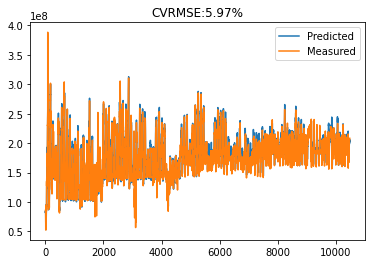

In [51]:
plt.plot(gru_outputs[0], label = "Predicted")
plt.plot(targets[0], label = "Measured")
mean_measured = abs(targets[0]).mean()
cvrmse = cvrmse_cal(targets[0],gru_outputs[0], mean_measured)
plt.title(f'CVRMSE:{cvrmse:.2f}%')
plt.legend()
plt.show()